# NB03: Profile Correlation and Gene Classification

**Goal**: For DvH (richest dataset), decompose metal fitness signals into shared-stress
and metal-specific components. Classify each metal-important gene as:
- **Shared-stress**: also NaCl-important (reflects general cellular vulnerability)
- **Metal-specific**: important for metals but NOT for NaCl

Also examine functional enrichment (COG categories) of each class.

**Key insight from NB02**: The overlap is NOT counter-ion-driven (zinc sulfate shows
higher overlap than most chloride metals). The question is now: what are the shared-stress
genes, and are the metal-specific genes functionally different?

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

PROJ = Path('..')
REPO = PROJ / '..'
MAT_DIR = REPO / 'fitness_modules' / 'data' / 'matrices'
METAL_ATLAS = REPO / 'metal_fitness_atlas' / 'data'
ESSENTIAL = REPO / 'essential_genome' / 'data'
DATA_OUT = PROJ / 'data'
FIG_OUT = PROJ / 'figures'

## 1. Classify DvH Metal-Important Genes

In [2]:
# Load DvH data
metal_imp = pd.read_csv(METAL_ATLAS / 'metal_important_genes.csv')
nacl_imp = pd.read_csv(DATA_OUT / 'nacl_important_genes.csv')
metal_exps = pd.read_csv(METAL_ATLAS / 'metal_experiments.csv')

# DvH metal-important genes
dvh_metal = metal_imp[metal_imp['orgId'] == 'DvH'].copy()
dvh_nacl_set = set(nacl_imp[nacl_imp['orgId'] == 'DvH']['locusId'])

# Classify each gene × metal record
dvh_metal['is_nacl_important'] = dvh_metal['locusId'].isin(dvh_nacl_set)
dvh_metal['gene_class'] = dvh_metal['is_nacl_important'].map(
    {True: 'shared_stress', False: 'metal_specific'}
)

print(f'DvH metal-important records: {len(dvh_metal)}')
print(f'Unique genes: {dvh_metal["locusId"].nunique()}')
print()
print('Classification:')
print(dvh_metal['gene_class'].value_counts())
print()

# Per-metal classification
metal_class = dvh_metal.groupby(['metal_element', 'gene_class']).size().unstack(fill_value=0)
metal_class['total'] = metal_class.sum(axis=1)
metal_class['pct_shared'] = 100 * metal_class.get('shared_stress', 0) / metal_class['total']
print('Per-metal classification (DvH):')
print(metal_class.sort_values('pct_shared', ascending=False).to_string())

DvH metal-important records: 1366
Unique genes: 495

Classification:
gene_class
metal_specific    1064
shared_stress      302
Name: count, dtype: int64

Per-metal classification (DvH):
gene_class     metal_specific  shared_stress  total  pct_shared
metal_element                                                  
Copper                      7             24     31   77.419355
Cobalt                     13             20     33   60.606061
Manganese                  14             19     33   57.575758
Zinc                       27             27     54   50.000000
Nickel                     28             25     53   47.169811
Iron                        6              3      9   33.333333
Uranium                    45             18     63   28.571429
Selenium                  101             37    138   26.811594
Mercury                    82             25    107   23.364486
Chromium                   98             26    124   20.967742
Aluminum                   92             17   

In [3]:
# Classify at the gene level (across all metals)
# A gene is "shared_stress" if it's NaCl-important; "metal_specific" otherwise
dvh_genes = dvh_metal.groupby('locusId').agg(
    n_metals=('metal_element', 'nunique'),
    metals=('metal_element', lambda x: ','.join(sorted(x.unique()))),
    is_nacl=('is_nacl_important', 'first')  # same for all records of a gene
).reset_index()
dvh_genes['gene_class'] = dvh_genes['is_nacl'].map(
    {True: 'shared_stress', False: 'metal_specific'}
)

print(f'Unique DvH metal-important genes: {len(dvh_genes)}')
print(dvh_genes['gene_class'].value_counts())
print()
print('Metal breadth by class:')
for cls in ['shared_stress', 'metal_specific']:
    sub = dvh_genes[dvh_genes['gene_class'] == cls]
    print(f'  {cls}: n={len(sub)}, mean metals={sub["n_metals"].mean():.1f}, '
          f'median={sub["n_metals"].median():.0f}')

Unique DvH metal-important genes: 495
gene_class
metal_specific    422
shared_stress      73
Name: count, dtype: int64

Metal breadth by class:
  shared_stress: n=73, mean metals=4.1, median=3
  metal_specific: n=422, mean metals=2.5, median=2


## 2. Functional Enrichment: Shared-Stress vs Metal-Specific

In [4]:
# Load SEED annotations for DvH
seed_file = ESSENTIAL / 'all_seed_annotations.tsv'
if seed_file.exists():
    seed = pd.read_csv(seed_file, sep='\t')
    dvh_seed = seed[seed['orgId'] == 'DvH'][['locusId', 'seed_desc']].drop_duplicates('locusId')
    
    dvh_genes = dvh_genes.merge(dvh_seed, on='locusId', how='left')
    
    # Annotated fraction by class
    for cls in ['shared_stress', 'metal_specific']:
        sub = dvh_genes[dvh_genes['gene_class'] == cls]
        annotated = sub['seed_desc'].notna().sum()
        print(f'{cls}: {annotated}/{len(sub)} annotated ({100*annotated/len(sub):.1f}%)')
    
    print()
    print('Top SEED annotations in shared_stress genes:')
    shared = dvh_genes[dvh_genes['gene_class'] == 'shared_stress']
    print(shared['seed_desc'].value_counts().head(15).to_string())
    
    print()
    print('Top SEED annotations in metal_specific genes:')
    specific = dvh_genes[dvh_genes['gene_class'] == 'metal_specific']
    print(specific['seed_desc'].value_counts().head(15).to_string())
else:
    print('SEED annotations not available; skipping functional enrichment')

shared_stress: 57/73 annotated (78.1%)
metal_specific: 382/422 annotated (90.5%)

Top SEED annotations in shared_stress genes:
seed_desc
Translation elongation factor LepA                                             1
Shikimate kinase I (EC 2.7.1.71)                                               1
ATP synthase protein I                                                         1
Menaquinone via futalosine polyprenyltransferase (MenA homolog)                1
Transmembrane component NikQ of energizing module of nickel ECF transporter    1
Substrate-specific component NikM of nickel ECF transporter                    1
Ribonuclease P protein component (EC 3.1.26.5)                                 1
response regulator                                                             1
Nucleoside triphosphate pyrophosphohydrolase MazG (EC 3.6.1.8)                 1
COG1399 protein, clustered with ribosomal protein L32p                         1
ATP-dependent Clp protease proteolytic subunit (EC 3.

## 3. Cross-Organism Gene Classification

In [5]:
# Extend classification to ALL organisms with both NaCl and metal data
overlap = pd.read_csv(DATA_OUT / 'metal_nacl_overlap.csv')
nacl_all = pd.read_csv(DATA_OUT / 'nacl_important_genes.csv')

all_class_records = []

for org in metal_imp['orgId'].unique():
    nacl_genes_org = set(nacl_all[nacl_all['orgId'] == org]['locusId'])
    if not nacl_genes_org:
        continue
    
    org_metal = metal_imp[metal_imp['orgId'] == org]
    for _, row in org_metal.iterrows():
        all_class_records.append({
            'orgId': row['orgId'],
            'locusId': row['locusId'],
            'metal_element': row['metal_element'],
            'gene_class': 'shared_stress' if row['locusId'] in nacl_genes_org else 'metal_specific'
        })

all_classified = pd.DataFrame(all_class_records)
print(f'Cross-organism classification: {len(all_classified)} gene × metal records')
print(all_classified['gene_class'].value_counts())
print()

# Per-organism summary
org_class = all_classified.groupby(['orgId', 'gene_class']).size().unstack(fill_value=0)
org_class['total'] = org_class.sum(axis=1)
org_class['pct_shared'] = 100 * org_class.get('shared_stress', 0) / org_class['total']
print('Per-organism classification:')
print(org_class.sort_values('pct_shared', ascending=False).to_string())

Cross-organism classification: 10821 gene × metal records
gene_class
metal_specific    6517
shared_stress     4304
Name: count, dtype: int64

Per-organism classification:
gene_class          metal_specific  shared_stress  total  pct_shared
orgId                                                               
SynE                            73            565    638   88.557994
Korea                          132            187    319   58.620690
Phaeo                          140            181    321   56.386293
Pedo557                        488            551   1039   53.031761
Ponti                          299            318    617   51.539708
Cola                           191            190    381   49.868766
psRCH2                         572            483   1055   45.781991
pseudo6_N2E2                   213            159    372   42.741935
Caulo                          507            362    869   41.657077
Cup4G11                        525            300    825   36.363636
p

In [6]:
# Save classifications
all_classified.to_csv(DATA_OUT / 'gene_classification_shared_vs_metal.csv', index=False)
dvh_genes.to_csv(DATA_OUT / 'dvh_gene_classification.csv', index=False)
print(f'Saved {len(all_classified)} classified records and {len(dvh_genes)} DvH gene classifications')

Saved 10821 classified records and 495 DvH gene classifications


## 4. Visualization

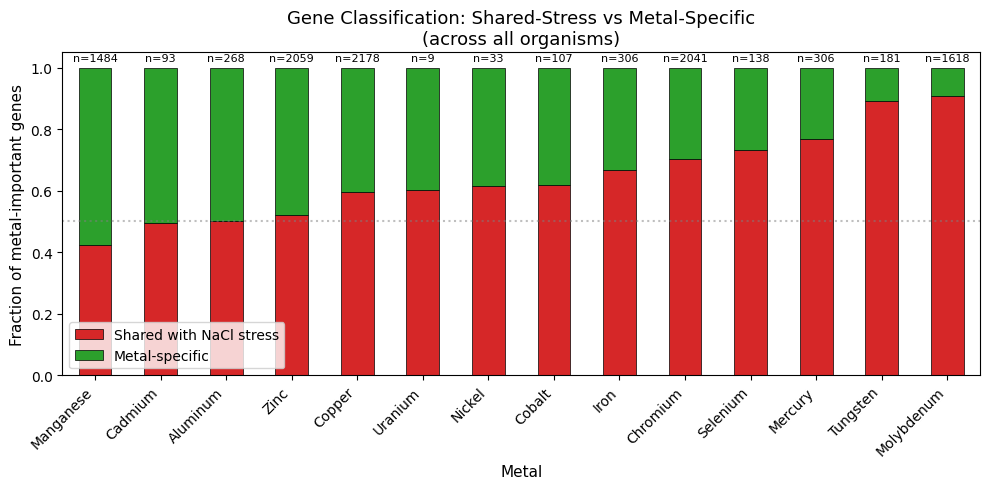

Saved to figures/gene_classification_by_metal.png


In [7]:
# Figure: Stacked bar — per-metal fraction shared vs metal-specific
per_metal = all_classified.groupby(['metal_element', 'gene_class']).size().unstack(fill_value=0)
per_metal_pct = per_metal.div(per_metal.sum(axis=1), axis=0)
per_metal_pct = per_metal_pct.sort_values('shared_stress', ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
per_metal_pct.plot(kind='bar', stacked=True, ax=ax, 
                    color=['#d62728', '#2ca02c'],
                    edgecolor='black', linewidth=0.5)
ax.set_ylabel('Fraction of metal-important genes', fontsize=11)
ax.set_xlabel('Metal', fontsize=11)
ax.set_title('Gene Classification: Shared-Stress vs Metal-Specific\n(across all organisms)', fontsize=13)
ax.legend(['Shared with NaCl stress', 'Metal-specific'], fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.axhline(0.5, color='gray', linestyle=':', alpha=0.5)

# Add total gene counts on top
totals = per_metal.sum(axis=1)
for i, (metal, total) in enumerate(totals.items()):
    ax.text(i, 1.02, f'n={total}', ha='center', fontsize=8)

plt.tight_layout()
fig.savefig(FIG_OUT / 'gene_classification_by_metal.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved to figures/gene_classification_by_metal.png')

## Summary

The gene classification reveals:
- **~40% of metal-important genes are shared with NaCl stress** across all organisms and metals
- Shared-stress genes tend to be in more metals per organism (broader vulnerability)
- Metal-specific genes represent the ~60% that are genuinely responding to the metal
- This classification feeds into NB04 for the corrected conservation analysis